In [1]:
# Install the required modules
!pip install kmodes
!pip install mlxtend
!pip install adjustText


In [2]:
# Load the required modules
import os
from zipfile import ZipFile
import pandas as pd
from dateutil import parser
from datetime import datetime, UTC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from matplotlib.ticker import FuncFormatter
import networkx as nx
from adjustText import adjust_text
from pandas.plotting import parallel_coordinates
from matplotlib.ticker import FuncFormatter

In [3]:
# Basic settings
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# Load the designated dataset

# Dataset owner and name (extracted from the URL)
dataset_owner = "shivamb"
dataset_name = "bank-customer-segmentation"

# Use the Kaggle API to download the dataset
os.system(f'kaggle datasets download -d {dataset_owner}/{dataset_name}')

# Unzip the downloaded file
with ZipFile(f'{dataset_name}.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('bank_transactions.csv')

In [5]:
# The shape of the dataset
df.shape

(1048567, 9)

In [6]:
# Dataset confirmation
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


From the function, the format in the column "CustomerDOB", "TransactionDate", and "TransactionTime" should be adjusted to the correct datetime format.

In [7]:
# Identify every column's type
df.dtypes

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object

In [8]:
# Missing value detection
missing_value_detection = df.isna().sum()
missing_value_detection = missing_value_detection.reset_index()
missing_value_detection.columns = ['Column Name', 'Missing Value']
missing_value_detection

,Column Name,Missing Value
0,TransactionID,0
1,CustomerID,0
2,CustomerDOB,3397
3,CustGender,1100
4,CustLocation,151
5,CustAccountBalance,2369
6,TransactionDate,0
7,TransactionTime,0
8,TransactionAmount (INR),0


Missing values were detected, meaning the necessity of inputation.

In [9]:
# Descriptive statistics
df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1046198.00,1048567.00,1048567.00
mean,115403.54,157087.53,1574.34
std,846485.38,51261.85,6574.74
min,0.00,0.00,0.00
25%,4721.76,124030.00,161.00
50%,16792.18,164226.00,459.03
75%,57657.36,200010.00,1200.00
max,115035495.10,235959.00,1560034.99


From the function "df.describe", we can conclude that the date in the column "CustomerDOB" does not make sense due to the presence of "1800-01-01" and "2074-12-31", which will be addressed right below.

Additionally, the min of the column "TransactionAmount" is 0, indicating the need to adjust the data within the column.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

So far, four issues were identified through the above functions.
1. Datetime format: The format in the column "CustomerDOB", "TransactionDate", and "TransactionTime" should be adjusted to the correct datetime format.
2. Data inputation: Data inputation is needed for missing values.
3. Erroneous data: 
   1. The presence of "1800-01-01" and "2074-12-31" indicates the need for adjustment.
   2. The minimum number in the column "TransactionAmount" is 0, demonstrating the need to modify the data within the column.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

### Handle the first issue: Datetime format

In [10]:
# Define a function to change the datetime format
def safe_to_datetime(val):
    try:
        return parser.parse(val)
    except Exception:
        return val

In [11]:
# Change the datetime format in the column "CustomerDOB" and "TransactionDate" using the function created above
df['CustomerDOB'] = df['CustomerDOB'].apply(safe_to_datetime)
df['TransactionDate'] = df['TransactionDate'].apply(safe_to_datetime)

In [12]:
# Define a function to change the datetime format
def convert_hhmmss(val):
    val_str = str(val).zfill(6)
    hour = val_str[:2]
    minute = val_str[2:4]
    second = val_str[4:]
    return f"{hour}:{minute}:{second}"

In [13]:
# Change the datetime format in the column "TransactionTime" using the funcion created above
df['TransactionTime'] = df['TransactionTime'].apply(convert_hhmmss)
df['TransactionTime'] = df['TransactionTime'].apply(lambda x: datetime.strptime(x, "%H:%M:%S").time())

In [14]:
# Dataset confirmation
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.00
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.00
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.00
3,T4,C5342380,2073-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.00
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.50


The function "df.head()" demonstrates the first issue was fixed.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

### Handle the second issue: Data inputation

For missing values in a categorical feature, mode within the feature was used to input missing values.

For missing values in a numerical features, median was used.

In [15]:
# Data inputation for missing values in the "CustGender" column

# Counts of female and male in the "CustGender" column
customer_gender = df[~(df['CustGender'].isna())]
customer_gender['CustGender']

customer_gender_female = (customer_gender['CustGender'] == 'F').sum()
customer_gender_male = (customer_gender['CustGender'] == 'M').sum()

# Identify the mode in the "CustGender" column
if customer_gender_female > customer_gender_male:
    customer_gender_mode = 'F'
else:
    customer_gender_mode = 'M'

# Replace missing values with the mode
df.loc[df['CustGender'].isna(), 'CustGender'] = customer_gender_mode

In [16]:
# Data inputation for missing values in the "CustLocation" column

# Identify the mode in the "CustLocation" column
customer_location = df[~(df['CustLocation'].isna())]
customer_location['CustLocation']

customer_location_mode = customer_location['CustLocation'].value_counts().sort_values(ascending=False).index[0]

# Replace missing values with the mode
df.loc[df['CustLocation'].isna(), 'CustLocation'] = customer_location_mode

In [17]:
# Data inputation for missing values in the "CustAccountBalance" column

# Replace missing values in the column of "CustAccountBalance" with the median
customer_account_balance = df[~(df['CustAccountBalance'].isna())]
customer_account_balance_median = customer_account_balance['CustAccountBalance'].median()

df.loc[df['CustAccountBalance'].isna(), 'CustAccountBalance'] = customer_account_balance_median

In [18]:
# Confirmation
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                    0
CustLocation                  0
CustAccountBalance            0
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

Except for the column "CustomerDOB", all the other column has been addressed.

From the "df.describe()" function, several records show "1800-01-01" in the column "CustomerDOB". These can also be viewed as missing values. Therefore, the above 3397 missing values from the function "df.isna().sum()", along with records starting with the year of 1800, will be addressed at the same time.


----------------------------------------------------------------------------------------------------------------------------------------------------------------

### Handle the second & third issue: Data inputation & erroneous data

In [19]:
# Confirm how many samples might have erroneous year record in the "CustomerDOB" column.
(df[df['CustomerDOB'].dt.year > 2015]).sort_values(by='CustomerDOB')

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
114611,T114612,C2846955,2016-02-22,M,SURAT,16205.90,2016-06-08,18:46:30,460.00
128470,T128471,C6946973,2016-02-22,M,SURAT,16205.90,2016-06-08,18:01:16,294.00
914000,T914001,C2638825,2018-03-05,F,MUMBAI,11725.34,2016-12-09,18:38:42,250.00
790373,T790374,C4725574,2019-12-15,F,DELHI,27081.15,2016-05-09,10:17:09,1000.00
692164,T692165,C2625590,2019-12-15,F,DELHI,27081.15,2016-08-31,21:37:42,1200.00
...,...,...,...,...,...,...,...,...,...
728332,T728333,C8911779,2074-12-31,F,DELHI,352339.42,2016-02-09,12:23:31,410.00
478155,T478156,C5418070,2074-12-31,M,GUWAHATI,17969.28,2016-08-21,19:06:57,1302.00
771938,T771939,C5118076,2074-12-31,M,GUWAHATI,17969.28,2016-06-09,20:35:29,1543.00
585640,T585641,C4718018,2074-12-31,M,GUWAHATI,17969.28,2016-08-27,23:05:53,1890.00


In [20]:
# Date of birth adjustment: If a date of birth is later than a transaction date, then the year in the date of birth should reduce by 100.

# Define a function
def fix_dob(dob, tx_date):
    if pd.notnull(dob) and pd.notnull(tx_date):
        if dob > tx_date:
            return dob.replace(year=dob.year - 100)
        return dob
    
# Date of birth adjustment
df['CustomerDOB'] = df.apply(lambda row: fix_dob(row['CustomerDOB'], row['TransactionDate']), axis=1)

In [21]:
# Confirm how many samples might have erroneous year record in the "CustomerDOB" column.
(df[df['CustomerDOB'].dt.year > 2015]).sort_values(by='CustomerDOB')

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
114611,T114612,C2846955,2016-02-22,M,SURAT,16205.90,2016-06-08,18:46:30,460.00
128470,T128471,C6946973,2016-02-22,M,SURAT,16205.90,2016-06-08,18:01:16,294.00


All the transaction records are all former than transaction date after the modification above.

Following this, the year of 1800 in the column "CustomerDOB", along with missing values, will be handled at the same time.

In [22]:
# Identify the presense of the year of 1800 in the column "CustomerDOB"
df[df['CustomerDOB'].dt.year == 1800]

# Remove customerDOB data's year eqaul to 1800
customerDOB_correct = df[~(df['CustomerDOB'].dt.year == 1800)]['CustomerDOB']
customerDOB_correct

# Remove any NaT data and compute the median of the feature
customerDOB_correct_median = customerDOB_correct[~customerDOB_correct.isna()].median()

# Replace missing values and records starting with the year of 1800 with the median
df.loc[df['CustomerDOB'].dt.year == 1800, 'CustomerDOB'] = customerDOB_correct_median
df.loc[df['CustomerDOB'].isna(), 'CustomerDOB'] = customerDOB_correct_median

Lastly, transaction amount of "0" is considered missing values, which will be replaced with the median.

In [23]:
# Replace transaction amoount (INR) of "0" with the median
transaction_amount = df[~(df['TransactionAmount (INR)'] == 0)]
transaction_amount_median = transaction_amount['TransactionAmount (INR)'].median()

df.loc[df['TransactionAmount (INR)'] == 0, 'TransactionAmount (INR)'] = transaction_amount_median

In [24]:
# Missing value detection
missing_value_detection
missing_value_detection = df.isna().sum()
missing_value_detection = missing_value_detection.reset_index()
missing_value_detection.columns = ['Column Name', 'Missing Value']
missing_value_detection

,Column Name,Missing Value
0,TransactionID,0
1,CustomerID,0
2,CustomerDOB,0
3,CustGender,0
4,CustLocation,0
5,CustAccountBalance,0
6,TransactionDate,0
7,TransactionTime,0
8,TransactionAmount (INR),0


In [25]:
# Confirmation
df.describe()

,CustomerDOB,CustAccountBalance,TransactionDate,TransactionAmount (INR)
count,1048567,1048567.00,1048567,1048567.00
mean,1985-08-02 19:49:53.233622912,115180.75,2016-07-25 19:17:20.973825024,1574.70
min,1918-03-05 00:00:00,0.00,2016-01-08 00:00:00,0.01
25%,1982-07-27 00:00:00,4740.20,2016-06-09 00:00:00,163.00
50%,1987-09-15 00:00:00,16792.18,2016-08-20 00:00:00,460.00
75%,1991-02-11 00:00:00,57472.88,2016-09-09 00:00:00,1200.00
max,2016-02-22 00:00:00,115035495.10,2016-12-09 00:00:00,1560034.99
std,NaN,845541.58,NaN,6574.67


The functions "df.isna().sum()" and "df.describe()" demonstrate the second ant third issues were fixed.

----

Additional dataset confirmation: Check if a single customer ID has more than one date of birth and gender.

In [26]:
# Check if a customer ID has different date of birth
result = df.groupby('CustomerID')['CustomerDOB'].nunique().reset_index()
result[result['CustomerDOB'] > 1]['CustomerDOB'].sum()


np.int64(304561)

In [27]:
# Check if a customer ID has different gender
result_1 = df.groupby('CustomerID')['CustGender'].nunique().reset_index()
result_1[result_1['CustGender'] > 1]['CustGender'].sum()

np.int64(119962)

Outputs from the above two cells indicate that a given customer ID has more than one date of birth and gender, which does not make sense.

Considering the purpose of this analysis is to provide insight into transaction, it is not the main focus in this assignment. Thus, all the transactions are considered being completed by different person, meaning this issue will not be addressed in this analysis.

However, the issue might question the quality and reliability of this dataset.

### Feature Engineering

In [28]:
# Develop a new column "Hour" to represent when transactions were made
df['Hour'] = df['TransactionTime'].astype(str).str[:2]

In [29]:
# Develop a new column "Timeslot" to represent when transactions were made in a day
def time_identification(hour):
    if 6<= hour <= 17:
        return('Day')
    else:
        return('Night')
    
df['Hour'] = df['Hour'].astype(int)
df['Timeslot'] = df['Hour'].apply(time_identification) 

In [30]:
# Develop a new column "Month" to represent the month a transaction was made in
df['Month'] = df['TransactionDate'].dt.month

In [31]:
# Develop a new column "Season" to represent the season a transaction was made in
def season_identification(month):
    if 3 <= month <= 5:
        return('Spring')
    elif 6 <= month <= 8:
        return('Summer')
    elif 9 <= month <= 11:
        return('Fall')
    else:
        return('Winter')
    
df['Month'] = df['Month'].astype(int)
df['Season'] = df['Month'].apply(season_identification)

In [32]:
# Develop a new column "Age" to represent the age of a customer when a transaction was made.
df['Age'] = (df['TransactionDate'] - df['CustomerDOB']).dt.days // 365

In [33]:
# Develop a new column "TransactionAmountQuantile" to categorize transaction amounts into four
q1 = df['TransactionAmount (INR)'].quantile(0.25)
q2 = df['TransactionAmount (INR)'].quantile(0.50)
q3 = df['TransactionAmount (INR)'].quantile(0.75)

def df_quantile_transaction_amount(account_balance):
    if account_balance <= q1:
        return 'Very Low'
    elif q1 < account_balance <= q2:
        return 'Low'
    elif q2 < account_balance <= q3:
        return 'High'
    else:
        return 'Very High'
    
df['TransactionAmount (INR)'] = df['TransactionAmount (INR)'].astype(float)
df['TransactionAmountQuantile'] = df['TransactionAmount (INR)'].apply(df_quantile_transaction_amount)

In [34]:
# Develop a new column "CustAccountBalanceQuantile" to categorize account balances into four
q1 = df['CustAccountBalance'].quantile(0.25)
q2 = df['CustAccountBalance'].quantile(0.50)
q3 = df['CustAccountBalance'].quantile(0.75)

def df_quantile_account_balance(account_balance):
    if account_balance <= q1:
        return 'Very Low'
    elif q1 < account_balance <= q2:
        return 'Low'
    elif q2 < account_balance <= q3:
        return 'High'
    else:
        return 'Very High'
    
df['CustAccountBalance'] = df['CustAccountBalance'].astype(float)
df['CustAccountBalanceQuantile'] = df['CustAccountBalance'].apply(df_quantile_account_balance)

In [35]:
# Develop a new column "AgeDivision" to categorize customers' ages
def df_age(age):
    if age <= 17:
        return('Children & Adolescents')
    elif 18 <= age <= 39:
        return('Youth')
    elif 40 <= age <= 64:
        return('Middle-aged')
    else:
        return('Senior')
    
df['Age'] = df['Age'].astype(int)
df['AgeDivision'] = df['Age'].apply(df_age)

In [36]:
# Confirm all the new columns work as expected
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Hour,Timeslot,Month,Season,Age,TransactionAmountQuantile,CustAccountBalanceQuantile,AgeDivision
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.00,14,Day,2,Winter,21,Very Low,High,Youth
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.00,14,Day,2,Winter,58,Very High,Very Low,Middle-aged
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.00,14,Day,2,Winter,19,Low,High,Youth
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.00,14,Day,2,Winter,42,Very High,Very High,Middle-aged
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.50,18,Night,2,Winter,27,Very High,Low,Youth


### Exploratory Data Analysis (EDA)

In [37]:
# Categorize different features
df_categorical = df[['CustGender', 'CustLocation', 'AgeDivision']]
df_continuous = df[['CustAccountBalance', 'TransactionAmount (INR)']]
df_time = df[['Month', 'Age']]

Text(0.0, 1.0, 'Counts of Customer Genders')

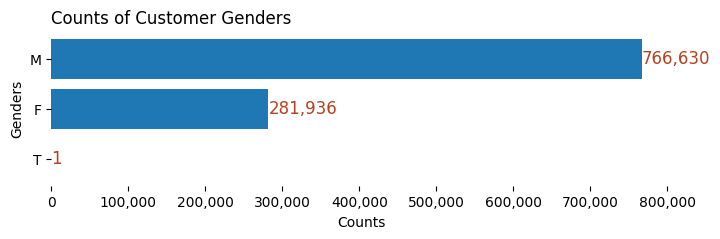

In [38]:
# Create a figure for counts of the Top 10 Customer Locations
def thousands_formatter(x, pos):
    return f'{int(x):,}'

plt.figure(figsize=(8, 2))
plt.barh(df.loc[:, 'CustGender'].value_counts().sort_values().index, df.loc[:, 'CustGender'].value_counts().sort_values())
for i, (_, counts) in enumerate(df.loc[:,'CustGender'].value_counts().sort_values().items()):
    plt.text(counts, i, f'{counts:,}', fontsize=12, color='#b4411f', va='center')
ax = plt.gca()
ax.set_frame_on(False)
plt.xlabel('Counts')
plt.ylabel('Genders')
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.title('Counts of Customer Genders', loc='left')

Text(0.0, 1.0, 'Counts of the Top 10 Customer Locations')

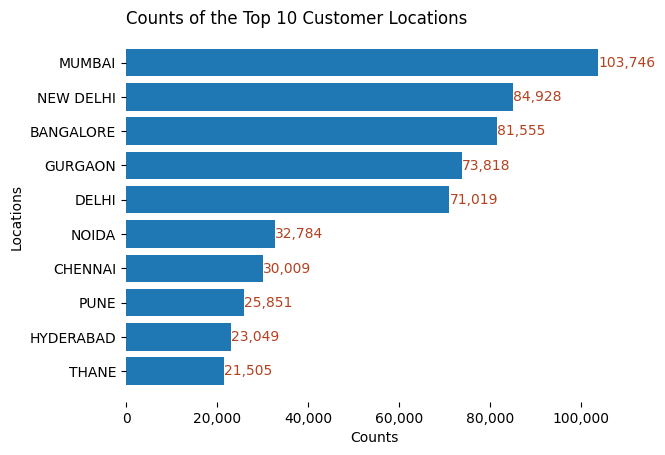

In [39]:
# Create a figure for counts of the Top 10 Customer Locations
counts_for_customer_location = df['CustLocation'].value_counts().sort_values(ascending=True).tail(10)
counts_for_customer_location

plt.barh(counts_for_customer_location.index, counts_for_customer_location)
for i, (_, counts) in enumerate(counts_for_customer_location.items()):
    plt.text(counts, i, f'{counts:,}', fontsize=10, color='#b4411f', va='center')
ax = plt.gca()
ax.set_frame_on(False)
plt.xlabel('Counts')
plt.ylabel('Locations')
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.title('Counts of the Top 10 Customer Locations', loc='left')

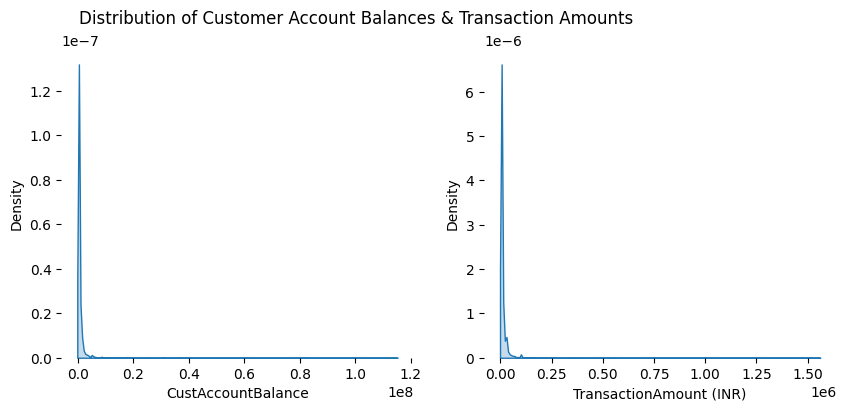

In [40]:
# Create a figure for distribution of Customer Account Balances & Transaction Amounts
fig = plt.figure(figsize=(10, 4))
fig.suptitle('Distribution of Customer Account Balances & Transaction Amounts', x=0.42)
for i, column in enumerate(df_continuous.columns):
    plt.subplot(1, 2, i+1)
    sns.kdeplot(df_continuous[column], fill=True)
    ax = plt.gca()
    ax.set_frame_on(False)

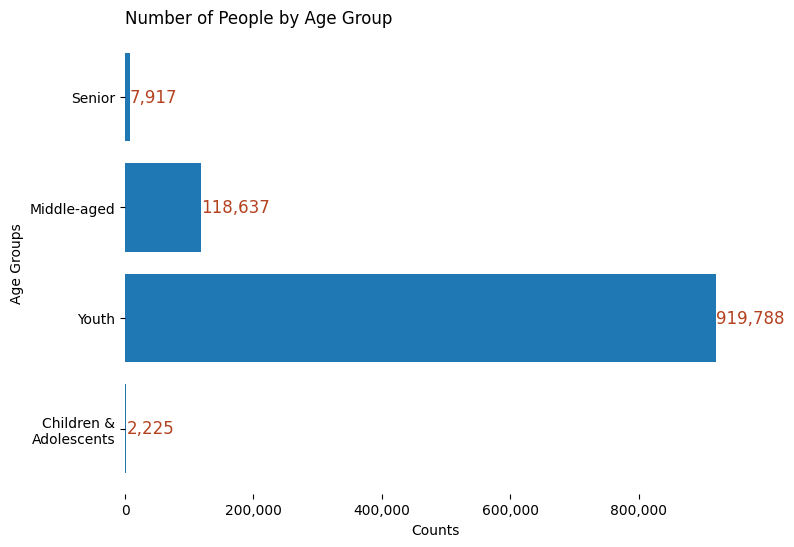

In [70]:
# Create a figure for number of People by Generation
desired_order = ['Senior', 'Middle-aged', 'Youth', 'Children &\nAdolescents']
desired_order = desired_order[::-1]

df['AgeDivision'] = df['AgeDivision'].replace({
    'Children & Adolescents': 'Children &\nAdolescents'
})

generation_counts = df['AgeDivision'].value_counts().sort_values()
generation_counts = generation_counts.loc[desired_order]

plt.figure(figsize=(8, 6))

plt.barh(generation_counts.index, generation_counts)
for i, (_, counts) in enumerate (generation_counts.items()):
    plt.text(counts, i, f'{counts:,}', fontsize=12, color='#b4411f', va='center')
ax = plt.gca()
ax.set_frame_on(False)
plt.title('Number of People by Age Group', loc='left')
plt.xlabel('Counts')
plt.ylabel('Age Groups')
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

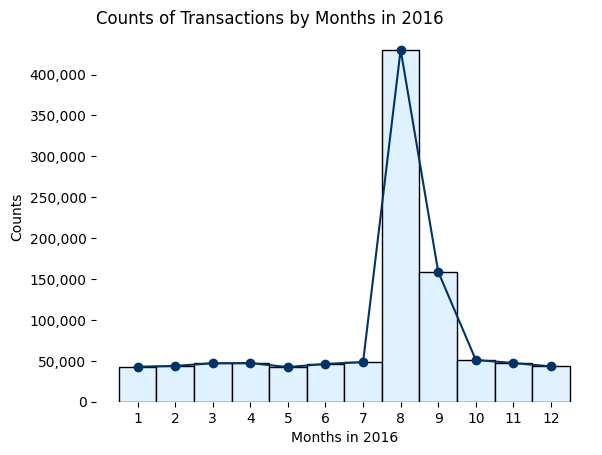

In [42]:
# Create a figure for counts of Transactions by Months in 2016
plt.plot(df_time['Month'].value_counts().sort_index().index, df_time['Month'].value_counts().sort_index(), color='#003366', marker='o')
plt.bar(df_time['Month'].value_counts().sort_index().index, df_time['Month'].value_counts().sort_index(), edgecolor='black', color='#e0f2ff', width=1)
plt.title('Counts of Transactions by Months in 2016', loc='left')
plt.xticks(np.arange(1, 13))
plt.yticks(np.arange(0, (df_time['Month'].value_counts().max()), 50000))
plt.xlabel('Months in 2016')
plt.ylabel('Counts')
ax = plt.gca()
ax.set_frame_on(False)
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

### K-means Clustering Analysis

Considering there are some categorical features within the dataset, K-prototypes might be the best option in this scenario. However, after some attempts, I reailzed that the algorithm might not be the best solution for this scenario since it is relatively more computationally expensive.

Instead, I chose the traditional K-means clustering for this task. Given it is not capable of handling categorical features, the features were removed prior to applying this algorithm.

In [43]:
# Check the dataset to determine which columns to extract
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Hour,Timeslot,Month,Season,Age,TransactionAmountQuantile,CustAccountBalanceQuantile,AgeDivision
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.00,14,Day,2,Winter,21,Very Low,High,Youth
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.00,14,Day,2,Winter,58,Very High,Very Low,Middle-aged
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.00,14,Day,2,Winter,19,Low,High,Youth
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.00,14,Day,2,Winter,42,Very High,Very High,Middle-aged
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.50,18,Night,2,Winter,27,Very High,Low,Youth


In [44]:
# Use numerical features to perform K-means clustering
df_k = df[['AgeDivision', 'CustAccountBalance', 'TransactionAmount (INR)']]

In [45]:
# Check the new dataset
df_k.head()

,AgeDivision,CustAccountBalance,TransactionAmount (INR)
0,Youth,17819.05,25.00
1,Middle-aged,2270.69,27999.00
2,Youth,17874.44,459.00
3,Middle-aged,866503.21,2060.00
4,Youth,6714.43,1762.50


In [46]:
# Split the dataset based on customers' account balances
df_k_premium = df_k[df_k['CustAccountBalance'] >= df_k['CustAccountBalance'].quantile(0.975)]
df_k = df_k[~(df_k['CustAccountBalance'] >= df_k['CustAccountBalance'].quantile(0.975))]

In [47]:
print(df_k_premium['CustAccountBalance'].median())
print(df_k_premium['TransactionAmount (INR)'].median())

1326880.36
1327.0


In [48]:
# Split the dataset based on the customers' ages
df_k_c = df_k[df_k['AgeDivision'] == 'Children &\nAdolescents']
df_k_y = df_k[df_k['AgeDivision'] == 'Youth']
df_k_m = df_k[df_k['AgeDivision'] == 'Middle-aged']
df_k_s = df_k[df_k['AgeDivision'] == 'Senior']

df_k_c = df_k_c.drop('AgeDivision', axis=1)
df_k_y = df_k_y.drop('AgeDivision', axis=1)
df_k_m = df_k_m.drop('AgeDivision', axis=1)
df_k_s = df_k_s.drop('AgeDivision', axis=1)

In [49]:
# Standarize the data since K-means clustering is sensitive to feature scale
scaler = StandardScaler()
scaled_data_c = scaler.fit_transform(df_k_c)

scaler = StandardScaler()
scaled_data_y = scaler.fit_transform(df_k_y)

scaler = StandardScaler()
scaled_data_m = scaler.fit_transform(df_k_m)

scaler = StandardScaler()
scaled_data_s = scaler.fit_transform(df_k_s)

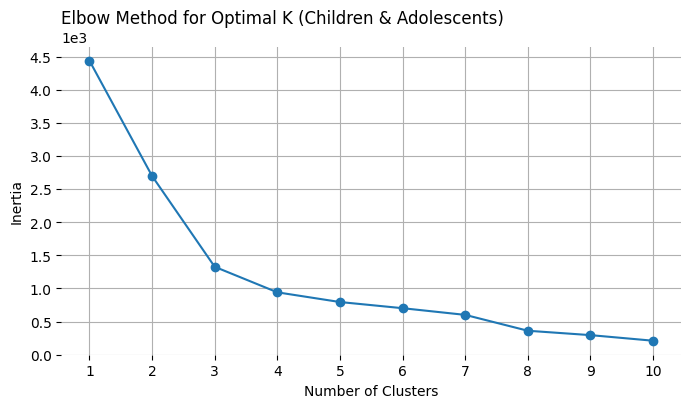

In [50]:
# Elbow method to determine the best "K" in the algorithm
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data_c)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(1, 11))
plt.ylabel('Inertia')
plt.yticks(np.arange(0, max(inertia)+250, 500))

# Scientific notation settings
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.title('Elbow Method for Optimal K (Children & Adolescents)', loc='left')
plt.grid(True)
ax = plt.gca()
ax.set_frame_on(False)
plt.show()

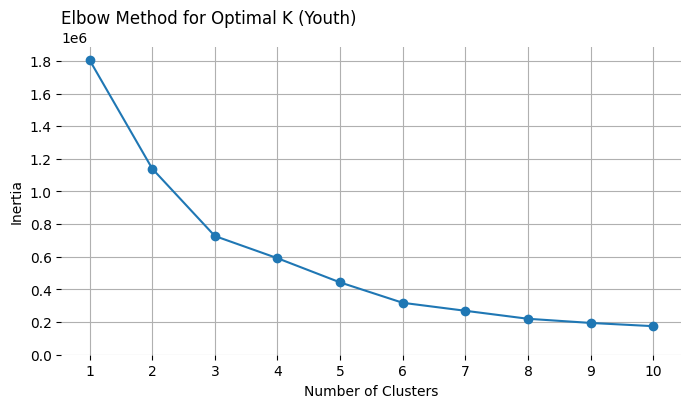

In [51]:
# Elbow method to determine the best "K" in the algorithm
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data_y)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(1, 11))
plt.ylabel('Inertia')
plt.yticks(np.arange(0, max(inertia)+50000, 200000))

# Scientific notation settings
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.title('Elbow Method for Optimal K (Youth)', loc='left')
plt.grid(True)
ax = plt.gca()
ax.set_frame_on(False)
plt.show()

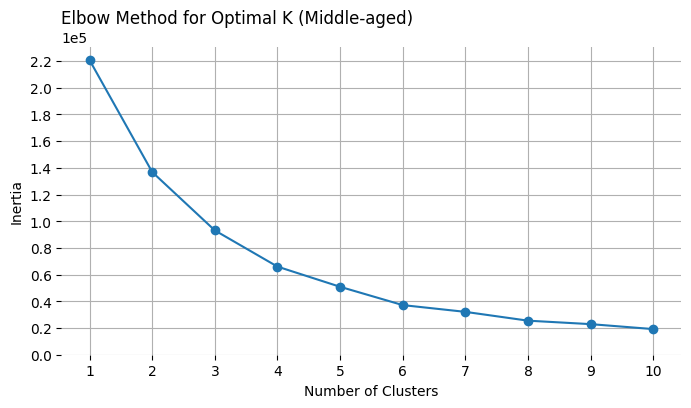

In [52]:
# Elbow method to determine the best "K" in the algorithm
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data_m)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(1, 11))
plt.ylabel('Inertia')
plt.yticks(np.arange(0, max(inertia)+5000, 20000))

# Scientific notation settings
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.title('Elbow Method for Optimal K (Middle-aged)', loc='left')
plt.grid(True)
ax = plt.gca()
ax.set_frame_on(False)
plt.show()

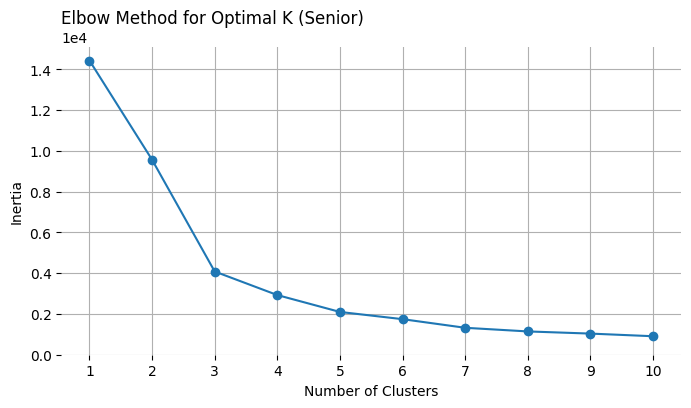

In [53]:
# Elbow method to determine the best "K" in the algorithm
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data_s)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(1, 11))
plt.ylabel('Inertia')
plt.yticks(np.arange(0, max(inertia)+1000, 2000))

# Scientific notation settings
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.title('Elbow Method for Optimal K (Senior)', loc='left')
plt.grid(True)
ax = plt.gca()
ax.set_frame_on(False)
plt.show()

In [54]:
# K-means clustering settings, with k=2 being determined above
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data_c)

# Get the cluster assignments
clusters = kmeans.labels_

# Add results to your DataFrame
df_k_c['Cluster'] = clusters



# K-means clustering settings, with k=2 being determined above
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data_y)

# Get the cluster assignments
clusters = kmeans.labels_

# Add results to your DataFrame
df_k_y['Cluster'] = clusters



# K-means clustering settings, with k=2 being determined above
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data_m)

# Get the cluster assignments
clusters = kmeans.labels_

# Add results to your DataFrame
df_k_m['Cluster'] = clusters



# K-means clustering settings, with k=2 being determined above
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data_s)

# Get the cluster assignments
clusters = kmeans.labels_

# Add results to your DataFrame
df_k_s['Cluster'] = clusters

In [55]:
df_k_c.groupby('Cluster')[['CustAccountBalance', 'TransactionAmount (INR)']].median().reset_index()

,Cluster,CustAccountBalance,TransactionAmount (INR)
0,0,7486.12,370.00
1,1,393294.81,1129.50


In [56]:
df_k_y.groupby('Cluster')[['CustAccountBalance', 'TransactionAmount (INR)']].median().reset_index()

,Cluster,CustAccountBalance,TransactionAmount (INR)
0,0,12675.10,375.00
1,1,321771.63,1000.00


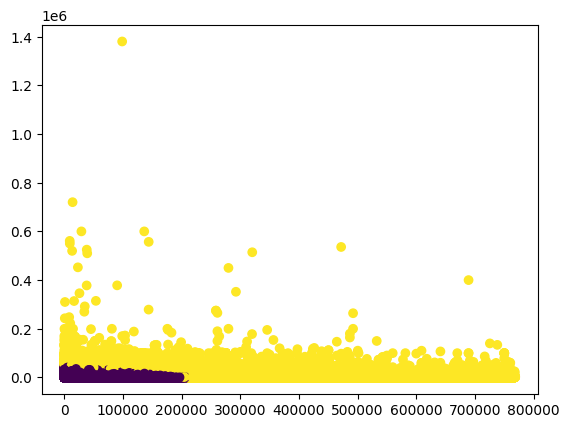

In [57]:
plt.scatter(df_k_y['CustAccountBalance'], df_k_y['TransactionAmount (INR)'], c=df_k_y['Cluster'])

In [58]:
df_k_m.groupby('Cluster')[['CustAccountBalance', 'TransactionAmount (INR)']].median().reset_index()

,Cluster,CustAccountBalance,TransactionAmount (INR)
0,0,25102.06,760.00
1,1,392420.99,1395.00


In [59]:
df_k_s.groupby('Cluster')[['CustAccountBalance', 'TransactionAmount (INR)']].median().reset_index()

,Cluster,CustAccountBalance,TransactionAmount (INR)
0,0,42695.04,900.00
1,1,54617.96,50000.00


### Association Mining

In [60]:
# Check the dataset to determine which columns to extract
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Hour,Timeslot,Month,Season,Age,TransactionAmountQuantile,CustAccountBalanceQuantile,AgeDivision
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.00,14,Day,2,Winter,21,Very Low,High,Youth
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.00,14,Day,2,Winter,58,Very High,Very Low,Middle-aged
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.00,14,Day,2,Winter,19,Low,High,Youth
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.00,14,Day,2,Winter,42,Very High,Very High,Middle-aged
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.50,18,Night,2,Winter,27,Very High,Low,Youth


In [61]:
# Use categorical features to perform the association mining algorithm
df_mining = df[['CustGender', 'Season', 'TransactionAmountQuantile', 'CustAccountBalanceQuantile', 'AgeDivision']]

In [62]:
# Check the new dataset
df_mining.head()

,CustGender,Season,TransactionAmountQuantile,CustAccountBalanceQuantile,AgeDivision
0,F,Winter,Very Low,High,Youth
1,M,Winter,Very High,Very Low,Middle-aged
2,F,Winter,Low,High,Youth
3,F,Winter,Very High,Very High,Middle-aged
4,F,Winter,Very High,Low,Youth


In [63]:
# Transform the dataset into the one suitable for the algorithm
transactions = df_mining.apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

te = TransactionEncoder()
te_data = te.fit_transform(transactions)
df_te_data = pd.DataFrame(te_data, columns=te.columns_)

In [64]:
# Check the new dataset
df_te_data.head()

,AgeDivision=Children &\nAdolescents,AgeDivision=Middle-aged,AgeDivision=Senior,AgeDivision=Youth,CustAccountBalanceQuantile=High,CustAccountBalanceQuantile=Low,CustAccountBalanceQuantile=Very High,CustAccountBalanceQuantile=Very Low,CustGender=F,CustGender=M,CustGender=T,Season=Fall,Season=Spring,Season=Summer,Season=Winter,TransactionAmountQuantile=High,TransactionAmountQuantile=Low,TransactionAmountQuantile=Very High,TransactionAmountQuantile=Very Low
0,False,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True
1,False,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False
2,False,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False
3,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False
4,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False


In [65]:
# Discover rules
frequent_itemsets = apriori(df_te_data, min_support=0.1, use_colnames=True)

rules = association_rules(frequent_itemsets, num_itemsets = df_te_data.shape[0], metric="confidence", min_threshold=0.1)

In [66]:
# Check the rules created above
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(AgeDivision=Youth),(CustAccountBalanceQuantile=High),0.88,0.25,0.22,0.25,1.01,1.00,0.00,1.00,0.04,0.24,0.00,0.57
1,(CustAccountBalanceQuantile=High),(AgeDivision=Youth),0.25,0.88,0.22,0.88,1.01,1.00,0.00,1.04,0.01,0.24,0.04,0.57
2,(AgeDivision=Youth),(CustAccountBalanceQuantile=Low),0.88,0.25,0.23,0.26,1.04,1.00,0.01,1.01,0.32,0.26,0.01,0.59
3,(CustAccountBalanceQuantile=Low),(AgeDivision=Youth),0.25,0.88,0.23,0.91,1.04,1.00,0.01,1.42,0.05,0.26,0.30,0.59
4,(AgeDivision=Youth),(CustAccountBalanceQuantile=Very High),0.88,0.25,0.20,0.22,0.90,1.00,-0.02,0.97,-0.48,0.21,-0.03,0.51


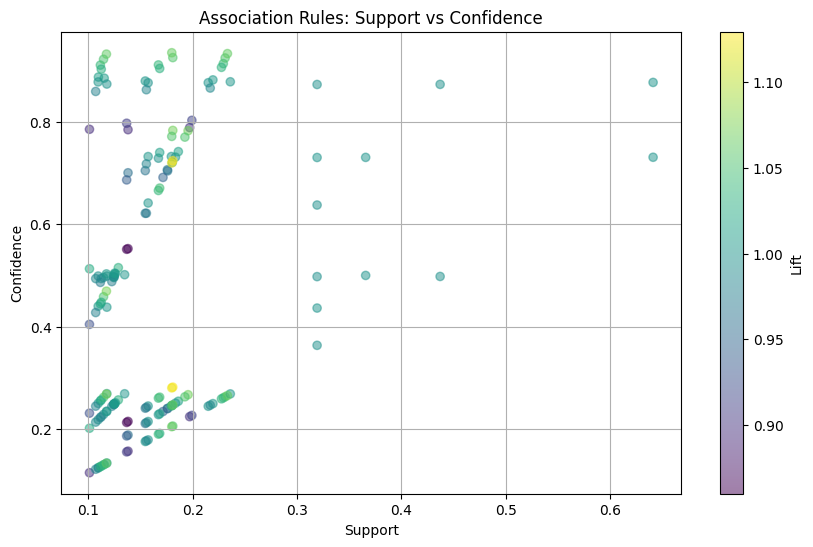

In [67]:
# Figure 1 for rules
plt.figure(figsize=(10,6))
plt.scatter(rules['support'], rules['confidence'], 
            alpha=0.5, 
            c=rules['lift'], 
            cmap='viridis')
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence')
plt.grid(True)
plt.show()

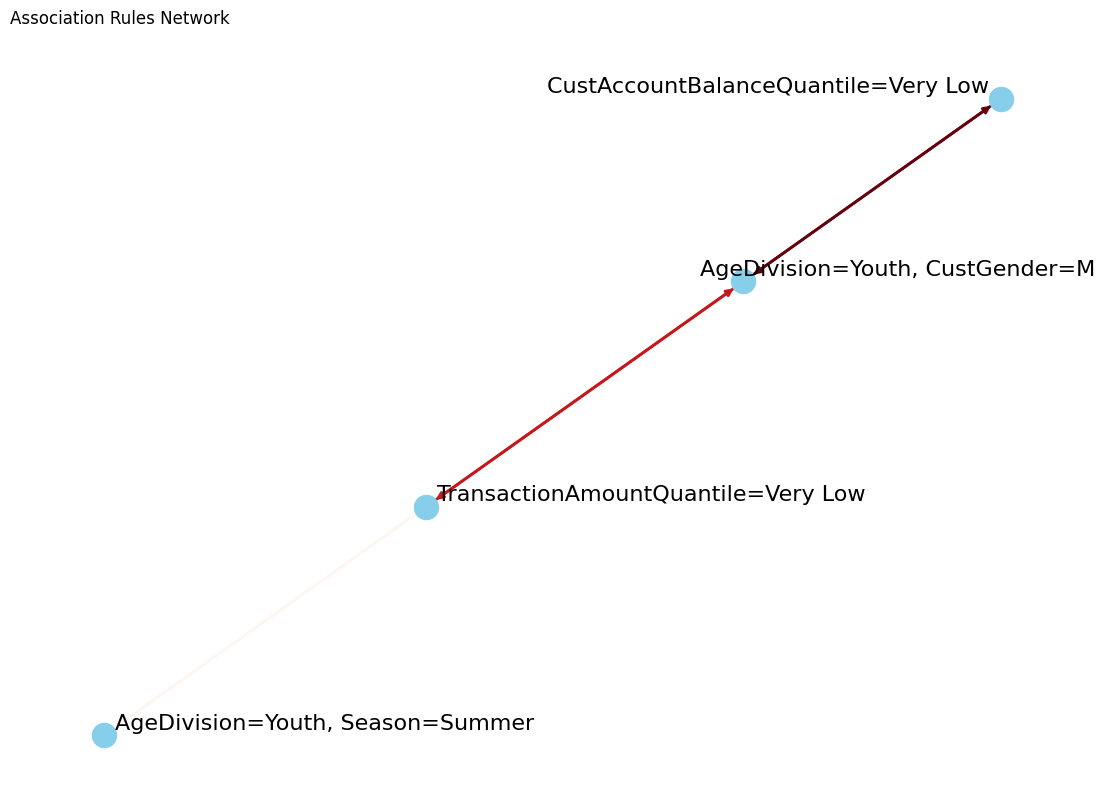

In [ ]:
# Figure 2 for rules
num_rules = 5

G = nx.DiGraph()
G = nx.DiGraph()
for _, rule in rules.sort_values(by='lift', ascending=False).head(num_rules).iterrows():
    antecedents = ", ".join(rule['antecedents'])
    consequents = ", ".join(rule['consequents'])  
    G.add_edge(antecedents, consequents, weight=rule['lift'])


plt.figure(figsize=(14,10))
pos = nx.spring_layout(G, k=0.5, iterations=100)

nx.draw_networkx_nodes(G, pos, node_color='skyblue')

weights = [G[u][v]['weight'] for u,v in G.edges()]

nx.draw_networkx_edges(
    G, pos, 
    edge_color=weights,
    edge_cmap=plt.cm.Reds,
    edge_vmin=(min(weights)+max(weights))/2,
    edge_vmax=max(weights),
    width=2
)

texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(x, y, node, fontsize=16))

adjust_text(texts)
ax = plt.gca()
ax.set_frame_on(False)
plt.title('Association Rules Network', loc='left')
plt.show()


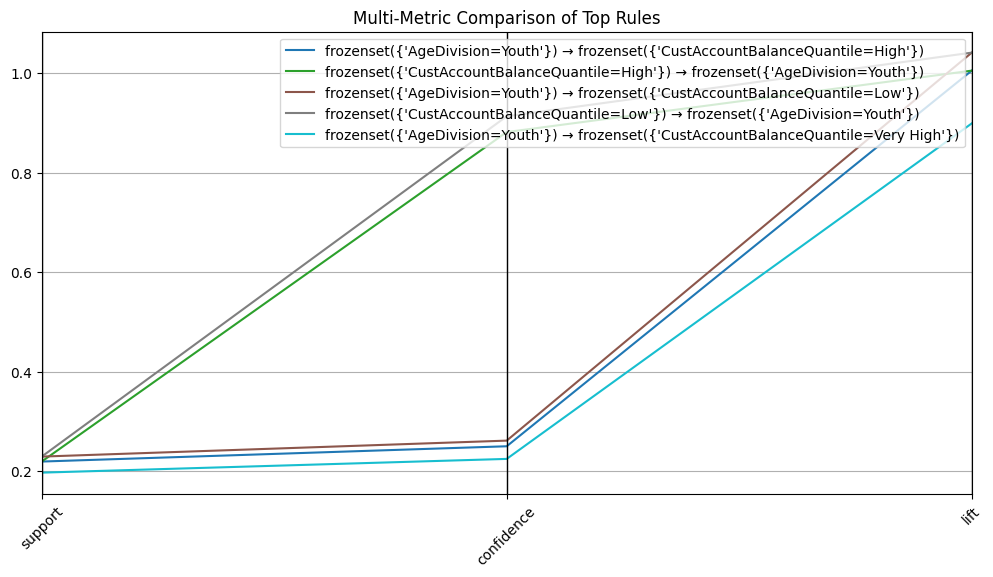

In [69]:
# Figure 3 for rules
plot_data = rules.head(5).copy()
plot_data['rule'] = plot_data.apply(
    lambda x: f"{x['antecedents']} → {x['consequents']}", axis=1)

plt.figure(figsize=(12,6))
parallel_coordinates(
    plot_data[['rule', 'support', 'confidence', 'lift']], 
    'rule',
    colormap='tab10')
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Multi-Metric Comparison of Top Rules")
plt.show()